In [80]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem
from collections import defaultdict
from itertools import accumulate
from ergochemics.mapping import rc_to_nest
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from cgr.ml import sep_aidx_to_bin_label

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from sklearn.calibration import CalibrationDisplay

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [ ]:
def get_reaction_center(am_rxn: str) -> list[list[list[int]], list[list[int]]]:
    sides = [elt.split('.') for elt in am_rxn.split('>>')]
    amn_to_midx_aidx = [] # Atom map num to mol idx, atom idx for lhs, rhs
    adj_mats = []
    for side in sides:
        tmp = {}
        for midx, smi in enumerate(side):
            mol = Chem.MolFromSmiles(smi)
            for atom in mol.GetAtoms():
                tmp[atom.GetAtomMapNum()] = (midx, atom.GetIdx())
        
        amn_to_midx_aidx.append(tmp)

        block_smi = ".".join(side)
        block_mol = Chem.MolFromSmiles(block_smi)
        block_aidx_to_amn = {atom.GetIdx(): atom.GetAtomMapNum() for atom in block_mol.GetAtoms()}
        A = Chem.GetAdjacencyMatrix(mol=block_mol, useBO=True)
        srt_idx = sorted([i for i in range(A.shape[0])], key=lambda x : block_aidx_to_amn[x])
        A = A[:, srt_idx][srt_idx]
        adj_mats.append(A)

    D = np.abs(adj_mats[1] - adj_mats[0])
    if len(amn_to_midx_aidx[0].keys() ^ amn_to_midx_aidx[1].keys()) != 0:
        raise ValueError("LHS and RHS atom maps do not perfectly intersect")

    rc_amns = np.flatnonzero(D.sum(axis=1)) + 1
    
    reaction_center = [[[] for _ in range(len(side))] for side in sides]
    for amn in rc_amns:
        for side_idx, lookup in enumerate(amn_to_midx_aidx):
            midx, aidx = lookup[amn]
            reaction_center[side_idx][midx].append(aidx)

    return reaction_center

def get_min_dist_to_rc(am_rxn: str, rc: list[list[list[int]], list[list[int]]]) -> list[list[list[int]], list[list[int]]]:
    mols = [[Chem.MolFromSmiles(elt) for elt in side.split('.')] for side in am_rxn.split('>>')]
    min_dists = [[], []]
    for i, side_rc in enumerate(rc):
        for mol, rc in zip(mols[i], side_rc):
            for atom in mol.GetAtoms():
                aidx = atom.GetIdx()
                min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

                min_dists[i].append(min_dist)
    return [np.array(elt).reshape(-1, 1) for elt in min_dists]


In [8]:
experiment_name = "outer_splits"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [9]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.test_precision,metrics.test_auroc,metrics.test_recall,...,params.data/inner_splitter/random_state,params.data/inner_splitter/_target_,params.data/outer_splitter/_target_,params.training/max_lr,params.study_version,tags.mlflow.user,tags.mlflow.runName,tags.source,tags.mlflow.source.type,tags.mlflow.source.name
0,4ef541b0e98f4ac5940b3a7491343b53,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:51:47.409000+00:00,2025-05-14 16:55:31.896000+00:00,0.089376,0.922377,0.979767,0.790553,...,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,5,spn1560,youthful-skink-802,train.py,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
1,ea7fc676bc224391adac4effa781eecf,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:59.104000+00:00,2025-05-14 16:46:57.102000+00:00,0.090822,0.870209,0.957251,0.709589,...,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0,spn1560,brawny-hawk-294,train.py,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
2,06179ac0c9b742e0b75ea920b59bc2a2,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:54.723000+00:00,2025-05-14 16:46:31.126000+00:00,0.092075,0.906544,0.977716,0.770664,...,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0,spn1560,rumbling-kit-889,train.py,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
3,690e593ce2ea492987e1d7c61849503b,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:45:35.026000+00:00,0.200481,0.754520,0.991205,0.965295,...,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0,spn1560,rogue-vole-197,train.py,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...
4,e9df2c14ceca475b95cb3165faef8959,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:50:25.655000+00:00,0.109731,0.797780,0.971402,0.808537,...,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0,spn1560,adorable-toad-359,train.py,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...


In [10]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.train_loss,metrics.test_precision,metrics.test_auroc,metrics.test_recall,metrics.test_loss,metrics.epoch,metrics.test_acc,metrics.test_auprc,params.training/final_lr,params.model/mp_depth,...,params.objective,params.training/init_lr,params.warmup_epochs,params.model/pred_head_d_hs,params.model/pred_head_name,params.data/inner_splitter/random_state,params.data/inner_splitter/_target_,params.data/outer_splitter/_target_,params.training/max_lr,params.study_version
3,0.200481,0.754520,0.991205,0.965295,0.119013,5.0,0.963204,0.948556,0.001,4,...,val_f1,0.0001,2,"[156, 161, 111]",ffn,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0
0,0.089376,0.922377,0.979767,0.790553,0.116239,7.0,0.952870,0.939413,0.001,4,...,val_f1,0.0001,2,"[181, 103]",ffn,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,5
2,0.092075,0.906544,0.977716,0.770664,0.110132,8.0,0.964769,0.912443,0.001,4,...,val_f1,0.0001,2,"[130, 196, 104]",ffn,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0
4,0.109731,0.797780,0.971402,0.808537,0.233754,18.0,0.947999,0.899109,0.001,4,...,val_f1,0.0001,2,"[200, 144, 156]",ffn,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0
1,0.090822,0.870209,0.957251,0.709589,0.160410,9.0,0.941155,0.876712,0.001,3,...,val_f1,0.0001,2,"[179, 123]",ffn,1234,sklearn.model_selection.GroupKFold,sklearn.model_selection.GroupKFold,0.0001,0


In [11]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [14]:
pred_df = pd.read_parquet(
    Path(row.artifact_uri.replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [15]:
preds = []
for _, row in df[df['params.objective'] == 'val_f1'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [ ]:
full = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_mechanistic_rules.parquet"
)
full["reaction_center"] = full["reaction_center"].apply(rc_to_nest)
full["template_aidxs"] = full["reaction_center"] # Rename atoms involved in mechinformed rules to template_aidxs
full["reaction_center"] = full["am_smarts"].apply(get_reaction_center) # Get the actual reaction center from the atom mapped reactions
full["min_dist_to_rc"] = full.apply(lambda x: get_min_dist_to_rc(x.am_smarts, x.reaction_center)[0], axis=1) # Get min dist to reaction center for lhs
full["binary_label"] = full.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for block mol
full.head()

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,template_aidxs,min_dist_to_rc,binary_label
0,1,CC(O)C(O)C(O)C(O)C(=O)O>>O.CC(O)C(O)CC(=O)C(=O)O,[CH3:11][CH:9]([OH:12])[CH:8]([OH:10])[CH:7]([...,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,"[[[6, 11, 9, 10, 7, 8, 5]], [[0], [9, 8, 10, 6...",841,"(((10, 9, 11, 7, 8, 5, 6),), ((0,), (0, 1, 2, ...","[[3], [2], [3], [1], [2], [0], [0], [0], [0], ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1...."
1,10,O=P(O)(O)OP(=O)(O)O.CCCCCCCCCCCC(=O)OP(=O)(O)O...,[O:10]=[P:1]([OH:2])([OH:11])[O:3][P:4](=[O:5]...,[*:1](~[O&D1&v2&H1&0*&!R:2])~[*:3]~[*:4](~[O&D...,"[[[8], [14, 13]], [[18, 15], [13]]]",632,"(((1, 2, 4, 5, 6, 7, 8), (14, 16, 13)), ((0, 1...","[[4], [3], [4], [4], [2], [1], [2], [2], [0], ...","[[0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1...."
2,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[*:1](~[O&D2&v2&H0&0*&!R:2]-[P&D4&v5&H0&0*&!R:...,"[[[16, 17], [0]], [[16], [1, 3]]]",813,"(((15, 16, 17, 19, 13, 14), (0,)), ((0, 1, 2, ...","[[12], [11], [12], [10], [9], [8], [7], [6], [...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
3,10001,Nc1c(NCC(O)C(O)C(O)CO)[nH]c(=O)[nH]c1=O.Cc1cc2...,[NH2:25][c:26]1[c:27]([NH:29][CH2:36][CH:37]([...,[N&D1&v3&H2&0*&!R:1]-[c&D3&v4&H0&0*&R&z1:2]:[c...,"[[[0, 1, 2, 3], [2, 3, 23, 24, 25, 1]], [[0, 1...",338,"(((0, 1, 2, 3, 13), (1, 2, 3, 4, 5, 12, 11, 9,...","[[0], [0], [0], [0], [1], [2], [3], [3], [4], ...","[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...."
4,10008,O.O=[N+]([O-])c1ccc(OP(=O)(O)O)cc1>>O=P(O)(O)O...,[OH2:5].[O:14]=[N+:13]([O-:15])[c:12]1[cH:10][...,[O&D0&v2&H2&0*&!R:1].[O&D2&v2&H0&0*&!R:2]-[P&D...,"[[[0], [11, 8, 9, 7]], [[0, 1, 3, 4], [7]]]",585,"(((0,), (7, 8, 9, 10, 11)), ((0, 1, 2, 3, 4), ...","[[0], [6], [5], [6], [4], [3], [2], [1], [0], ...","[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [146]:
bad_ids = set()
for _, row in full.iterrows():
    templates = row["template_aidxs"][0]
    rcs = row["reaction_center"][0]

    for template, rc in zip(templates, rcs):
        if len(set(rc) - set(template)) != 0:
            bad_ids.add(row["rxn_id"])
print(bad_ids)

{'7054', '8971', '6303', '16263', '1101', '3555', '5872', '3707', '12818', '6020'}


In [97]:
continuous_rxn_ids = []
for _, row in full.iterrows():
    continuous_rxn_ids.append(
        np.repeat(int(row["rxn_id"]), row["binary_label"].shape[0]).reshape(-1, 1)
    )

continuous_rxn_ids = np.vstack(continuous_rxn_ids)

y = np.vstack(full["binary_label"])
min_dist_rc = np.vstack(full["min_dist_to_rc"])
Rs = [0, 1, 2, 3, 4]
rcr_preds = {R: (min_dist_rc <= R).astype(np.int32) for R in Rs}
recall_from_rcr = [recall_score(y, rcr_preds[R]) for R in Rs]
precision_from_rcr = [precision_score(y, rcr_preds[R]) for R in Rs]
recall_from_rcr, precision_from_rcr

([0.5273371670807345,
  0.7103841275908198,
  0.8372800083392693,
  0.9088066158202888,
  0.965305165134905],
 [0.9993415204293287,
  0.6636855004950576,
  0.4980725307206565,
  0.4035082306113948,
  0.33884226960042935])

In [147]:
bad_ids = np.unique(continuous_rxn_ids[(rcr_preds[0] - y == 1)])
bad_ids

array([ 1101,  3555,  3707,  5872,  6020,  6303,  7054,  8971, 12818,
       16263])

In [142]:
row = full[full["rxn_id"] == '10024']
row

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,template_aidxs,min_dist_to_rc,binary_label
10,10024,CNCC(O)c1ccccc1.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=...,[CH3:1][NH:28][CH2:29][CH:30]([OH:31])[c:32]1[...,[C&D1&v4&H3&0*&!R&z1:1]-[N&D2&v3&H1&0*&!R:2].[...,"[[[0, 1], [14]], [[0, 1], [0]]]",42,"(((0, 1), (14,)), ((0, 1), (0,)))","[[0], [0], [1], [2], [3], [3], [4], [5], [6], ...","[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...."


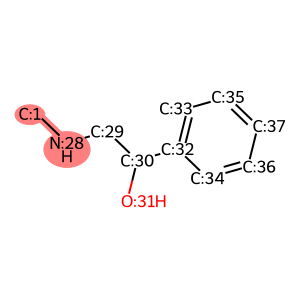

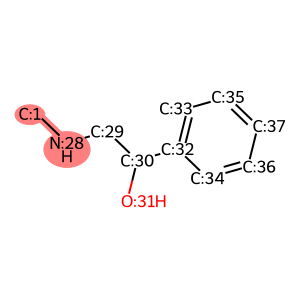

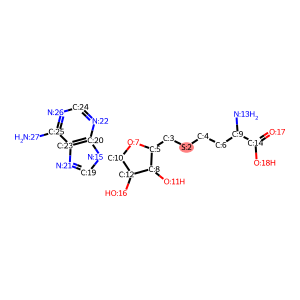

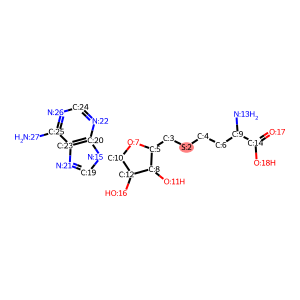

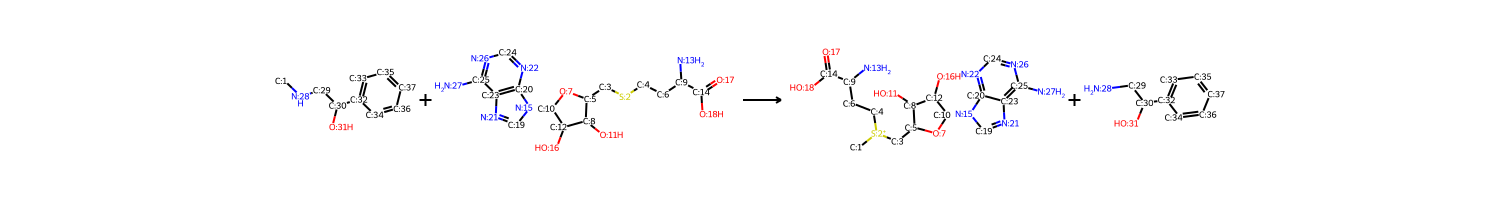

In [ ]:
am_rxn = row["am_smarts"].values[0]
lhs_mols = [Chem.MolFromSmiles(elt) for elt in am_rxn.split('>>')[0].split('.')]
for i, mol in enumerate(lhs_mols):
    template = row["template_aidxs"].values[0][0][i]
    rc = row["reaction_center"].values[0][0][i]
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=template, size=(300, 300))))
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=rc, size=(300, 300))))
display(SVG(draw_reaction(am_rxn)))

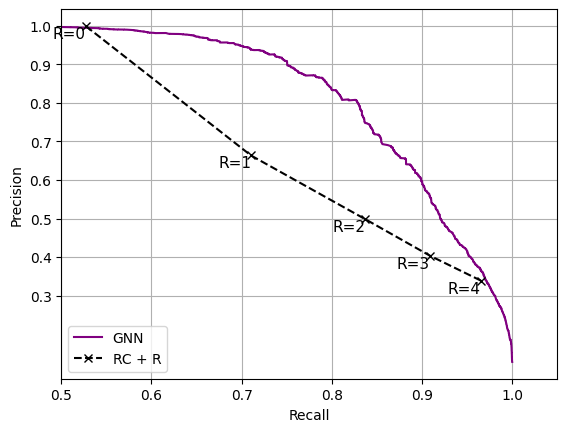

In [ ]:
# RC + R stats
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()

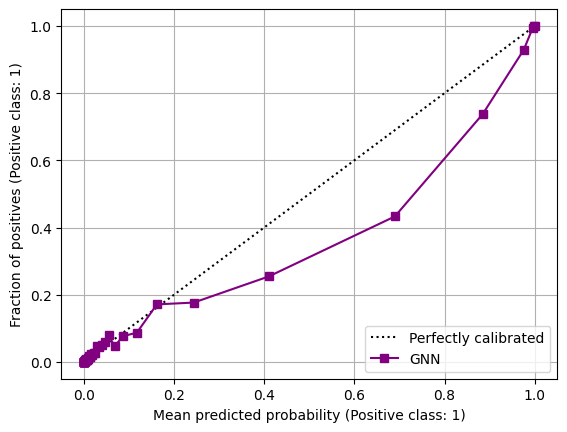

In [156]:
disp = CalibrationDisplay.from_predictions(
    pred_df.y,
    pred_df.y_pred,
    strategy="quantile",
    n_bins=50,
    name="GNN",
    color='purple',
)
plt.grid()
plt.show()